In [1]:
import networkx as nx
import numpy as np
from sklearn.neighbors import KDTree
import base
from importlib import reload
import matplotlib.pyplot as plt

import base as ba

In [2]:
reload(ba)

<module 'base' from '/home/bjoern/Desktop/Master2/N3D/Project/3DHarris/base.py'>

In [3]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
%matplotlib notebook

## Functions for the basic form generation

In [4]:
def create_line(start, end, num_points):
    '''
    Returns points on a line between start, end. (Including start, excluding end)
    '''
    if num_points <= 1:
        return np.array(start).reshape(-1,len(start))
    
    v = np.array(end)-np.array(start)
    points = []
    for i in range(int(num_points)):
        s = i / float(num_points)
        points.append(start + s*v)
        
    return  np.vstack(points)


def create_empty_square(length, height, grid_size):
    '''
    creates a flat square in 3D.
    of edge length 'length', with z-coordinate 'height'
    '''
    if np.isclose(length, 0.0):
        return np.array([[0,0,height]])
    
    corners = [(-length/2.0, -length/2.0, height),
              (-length/2.0, length/2.0, height),
              (length/2.0, length/2.0, height),
              (length/2.0, -length/2.0, height)]
    
    points = np.empty((0,3))
    for i in range(4):
        start = corners[i]
        end = corners[(i+1)%4]
        line = create_line(start, end, num_points=int(np.round(length/grid_size)))
        points = np.vstack([points, line])
    return points
    
def create_filled_square(length, height, grid_size):
    if np.isclose(length, 0.0):
        return np.array([[0,0,height]])
    
    coords = np.linspace(-length/2.0,length/2.0,length/float(grid_size)+1)
    xs, ys, zs = np.meshgrid(coords,coords,[float(height)])
    square = np.vstack([xs.flatten(), ys.flatten(), zs.flatten()]).T
    return square
    

def create_pyramid(ground_length, height, grid_size):    
    points = np.empty((0,3))
    
    # Ground (filled square)
    points = create_filled_square(ground_length, height=0.0, grid_size=grid_size)
    
    # Middle part (empty squares)
    factor_space = np.linspace(0.0,1.0,height/float(grid_size)+1)
    for f in factor_space[1:]:
        crt_height = f * height
        crt_length = (1-f)*ground_length
        square = create_empty_square(crt_length, crt_height, grid_size)
        points = np.vstack([points, square])
    return points
    
    
def create_cube(edge_length, grid_size):
    # Ground
    points = create_filled_square(edge_length, height=0.0, grid_size=grid_size)
    
    # Squares in the middle
    heights = np.linspace(grid_size, edge_length-grid_size, edge_length/grid_size-1)
    for height in heights:
        square = create_empty_square(edge_length, height, grid_size)
        points = np.vstack([points, square])
    
    # Top
    square = create_filled_square(edge_length, height=edge_length, grid_size=grid_size)
    points = np.vstack([points, square])
    return  points

# Pyramid 

<IPython.core.display.Javascript object>


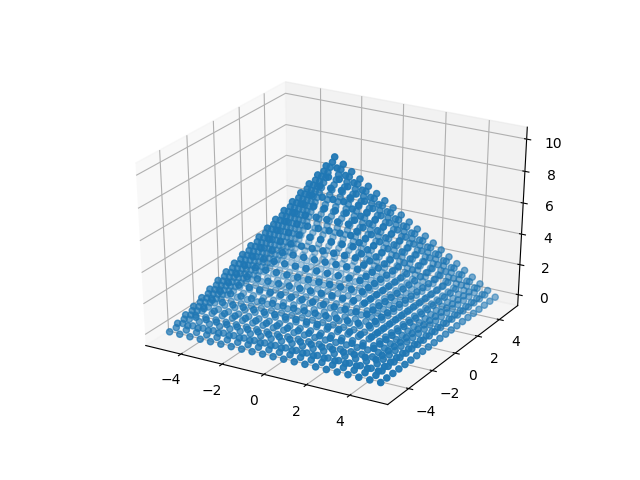

3606 points


In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pyramid = create_pyramid(ground_length=10,height=10,grid_size=0.5)
pyramid += 0.001*np.random.randn(*pyramid.shape)
ax.scatter(pyramid[:,0],pyramid[:,1],pyramid[:,2])
print(pyramid.size,'points')
fig.savefig("pyramid")

In [6]:
MG = base.Meshgrid(pyramid)
diag = np.linalg.norm(np.min(pyramid,axis=0) - np.max(pyramid,axis=0))
#print('Max_dist:',max_dist)
MG.compute_all_harris_responses(neigh_flag='k', neigh_args={'k':50}, k_harris=0.04)
harris_values = MG.harris_values
print('min harris   ',np.min(harris_values))
print('median harris',np.median(harris_values))
print('max harris   ',np.max(harris_values))

min harris    -1.0596669413803024
median harris 1.0883317298146593e-15
max harris    4.172076666770673


In [8]:
top_idx = np.argsort(pyramid[:,2])[-1]
print(top_idx)

1201


In [9]:
harris,rotated_neigh,orig_neighborhood, centroid, normal,normalized_neighborhood,new_points_before_centered,p, new_index, graph= MG.compute_all_harris_responses_debug( top_idx ,neigh_flag = 'k', neigh_args = {'k':50},  k_harris = 0.04)

In [10]:
idx_neigh = np.argsort(orig_neighborhood[:,2])[-1]
print(idx_neigh)

31


<IPython.core.display.Javascript object>


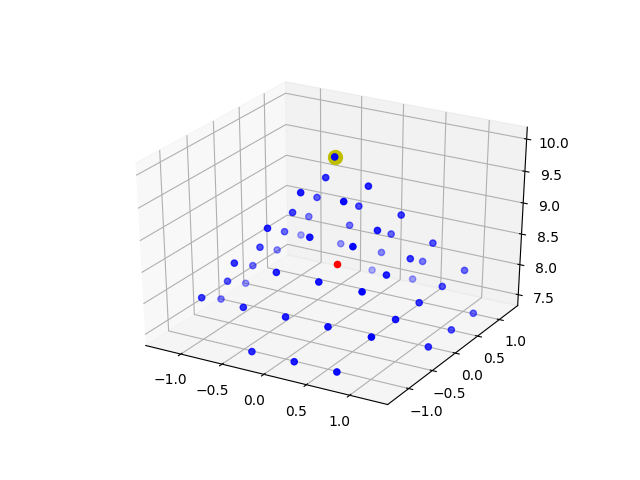

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(orig_neighborhood[:,0],orig_neighborhood[:,1],orig_neighborhood[:,2], c='b')
ax.scatter(orig_neighborhood[idx_neigh,0],orig_neighborhood[idx_neigh,1],orig_neighborhood[idx_neigh,2], c='y', s = 100)
ax.scatter(centroid[0],centroid[1],centroid[2], c='r')

In [12]:
centered_neigh = orig_neighborhood - centroid

In [13]:
def line(vector ,points = 5 ):
    normal_line_x = [i * vector[0] for i in range(0,points)] 
    normal_line_y = [i * vector[1] for i in range(0,points)] 
    normal_line_z = [i * vector[2] for i in range(0,points)] 
    normal_line = np.stack([normal_line_x, normal_line_y, normal_line_z], axis = 1)
    return normal_line 

<IPython.core.display.Javascript object>


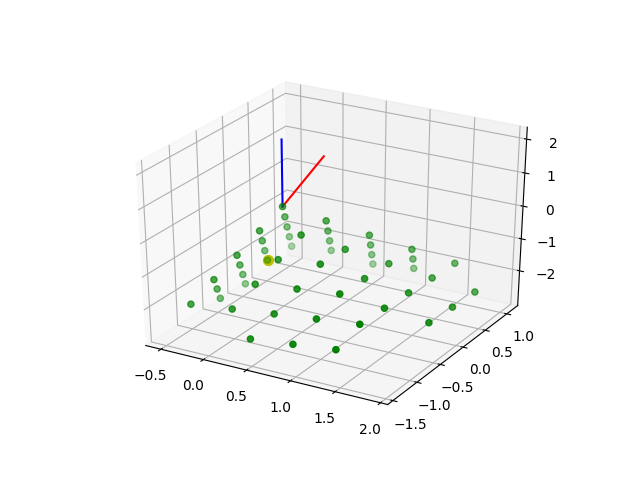

In [15]:
aim = np.array([0,0,1])
normal_line = line(normal, 3)
aim_line = line(aim, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(centered_neigh[:,0],centered_neigh[:,1],centered_neigh[:,2])
#ax.scatter(centered_neigh[idx_neigh,0],centered_neigh[idx_neigh,1],centered_neigh[idx_neigh,2], c = "y", s=70)
ax.plot(normal_line[:,0],normal_line[:,1],normal_line[:,2], c="r")
ax.plot(aim_line[:,0],aim_line[:,1],aim_line[:,2], c="b")
ax.scatter(normalized_neighborhood[:,0],normalized_neighborhood[:,1],normalized_neighborhood[:,2], c="g")
ax.scatter(normalized_neighborhood[32,0],normalized_neighborhood[32,1],normalized_neighborhood[32,2], c="y",s=50)
#a1 = 2
#a2 = 3
#ax.scatter(centered_neigh[2,0],centered_neigh[2,1],centered_neigh[2,2], c = "r", s=70)

<IPython.core.display.Javascript object>


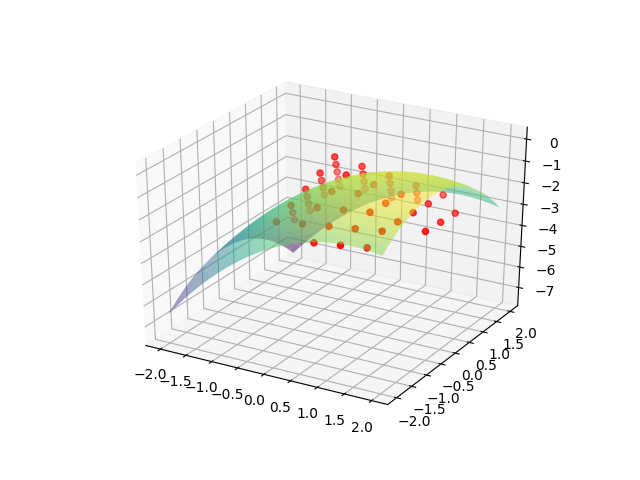

In [16]:
x = np.outer(np.linspace(-2, 2, 30), np.ones(30))
y = x.copy().T # transpose
z = p[0]/2 * (x**2) + p[1] * (x*y) + p[2]/2 * (y**2) + p[3] * x + p[4] * y + p[5]
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z,cmap='viridis', edgecolor='none', alpha = 0.5)
ax.scatter(normalized_neighborhood[:,0],normalized_neighborhood[:,1],normalized_neighborhood[:,2], c="r")


<IPython.core.display.Javascript object>


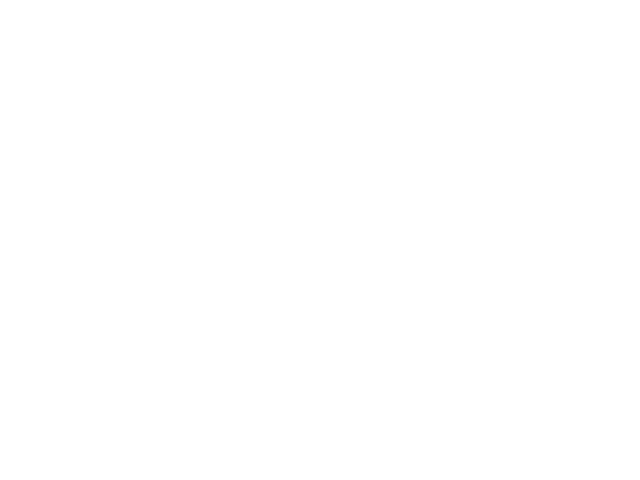

In [17]:
indices_smallest = np.argsort(harris_values)[int(0.0*len(harris_values)):int(0.01*len(harris_values))]
indices_largest = np.argsort(harris_values)[int(0.99*len(harris_values)):int(1.0*len(harris_values))]
pyramid_smallest = pyramid[indices_smallest]
pyramid_largest = pyramid[indices_largest]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pyramid_smallest[:,0],pyramid_smallest[:,1],pyramid_smallest[:,2],c='b')
ax.scatter(pyramid_largest[:,0],pyramid_largest[:,1],pyramid_largest[:,2],c='r')
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.set_zlim(-0,10)
fig.savefig("pyramid_1_high_low")

<IPython.core.display.Javascript object>


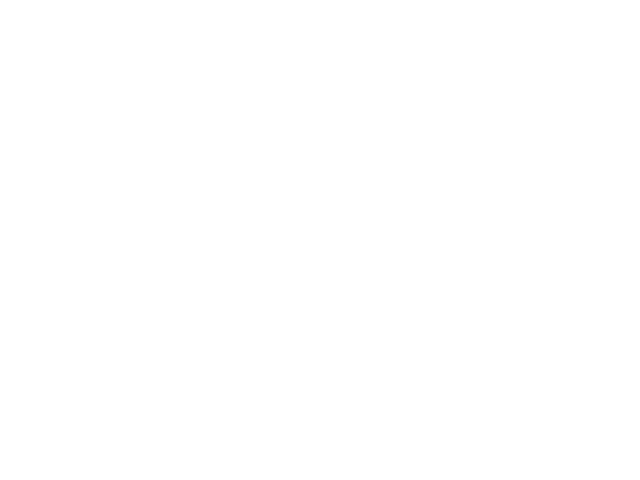

In [18]:
indices = np.argsort(harris_values)[int(0*len(harris_values)):int(1.0*len(harris_values))]
pyramid_new = pyramid[indices]
harris_new = harris_values[indices]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pyramid_new[:,0],pyramid_new[:,1],pyramid_new[:,2],c=np.linspace(0,1,len(pyramid_new)),cmap='seismic')
#ax.scatter(pyramid_new[:,0],pyramid_new[:,1],pyramid_new[:,2],c=harris_new,cmap='seismic')
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_zlim(-0,11)
fig.savefig("pyramid_all")

## Pyramid edge

<IPython.core.display.Javascript object>


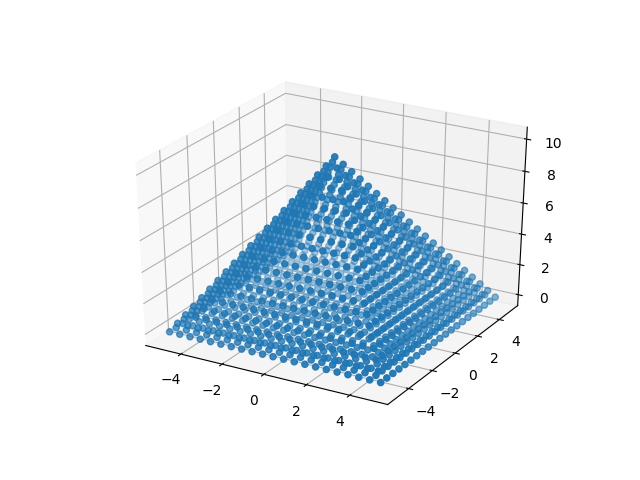

3606 points


In [19]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pyramid = create_pyramid(ground_length=10,height=10,grid_size=0.5)
pyramid += 0.001*np.random.randn(*pyramid.shape)
ax.scatter(pyramid[:,0],pyramid[:,1],pyramid[:,2])
print(pyramid.size,'points')

<IPython.core.display.Javascript object>


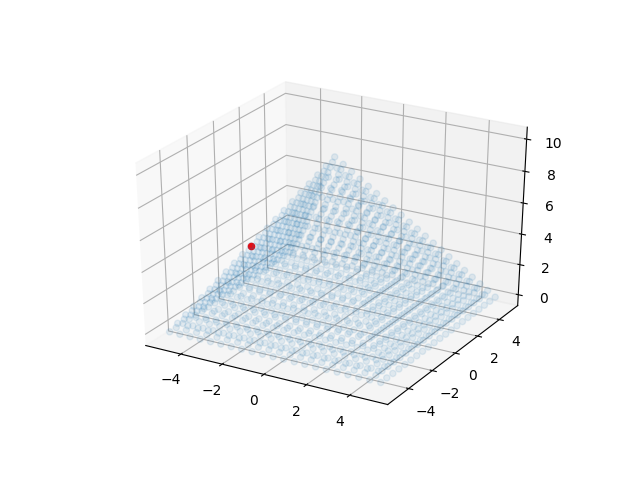

3606 points


In [20]:
a1 = 981
a2 = 982
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pyramid = create_pyramid(ground_length=10,height=10,grid_size=0.5)
pyramid += 0.001*np.random.randn(*pyramid.shape)
ax.scatter(pyramid[a1:a2,0],pyramid[a1:a2,1],pyramid[a1:a2,2], c='r')
ax.scatter(pyramid[:,0],pyramid[:,1],pyramid[:,2], alpha = 0.1)
print(pyramid.size,'points')

In [21]:
harris,rotated_neigh,orig_neighborhood, centroid, normal,normalized_neighborhood,new_points_before_centered,p, indx_new, graph= MG.compute_all_harris_responses_debug( 981 ,neigh_flag = 'k', neigh_args = {'k':50},  k_harris = 0.04)

### Neighborhood

<IPython.core.display.Javascript object>


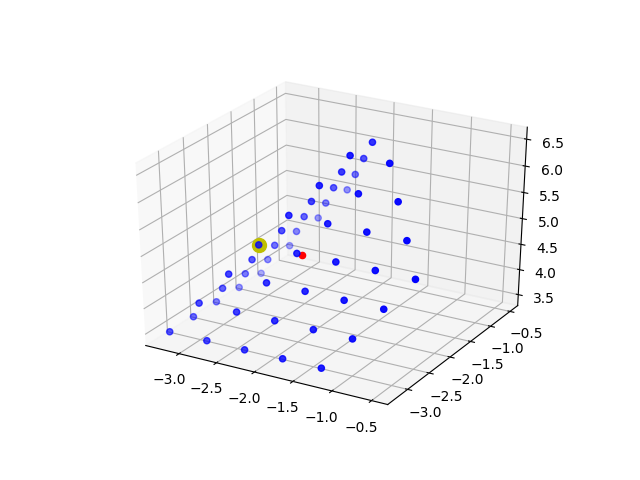

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(orig_neighborhood[:,0],orig_neighborhood[:,1],orig_neighborhood[:,2], c='b')
ax.scatter(orig_neighborhood[indx_new,0],orig_neighborhood[indx_new,1],orig_neighborhood[indx_new,2], c='y', s = 100)
ax.scatter(centroid[0],centroid[1],centroid[2], c='r')

<IPython.core.display.Javascript object>


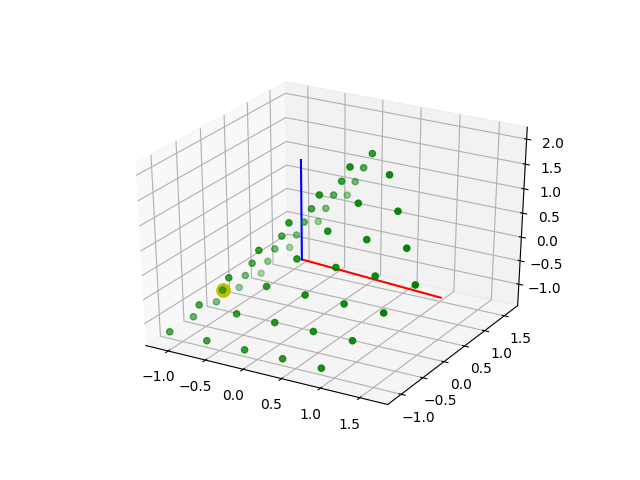

In [23]:
centered_neigh = orig_neighborhood - centroid
aim = np.array([0,0,1])
normal_line = line(normal, 3)
aim_line = line(aim, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(normal_line[:,0],normal_line[:,1],normal_line[:,2], c="r")
ax.plot(aim_line[:,0],aim_line[:,1],aim_line[:,2], c="b")
ax.scatter(centered_neigh[:,0],centered_neigh[:,1],centered_neigh[:,2], c="g")
ax.scatter(centered_neigh[new_index,0],centered_neigh[new_index,1], centered_neigh[new_index,2], c="y", s=90 )

<IPython.core.display.Javascript object>


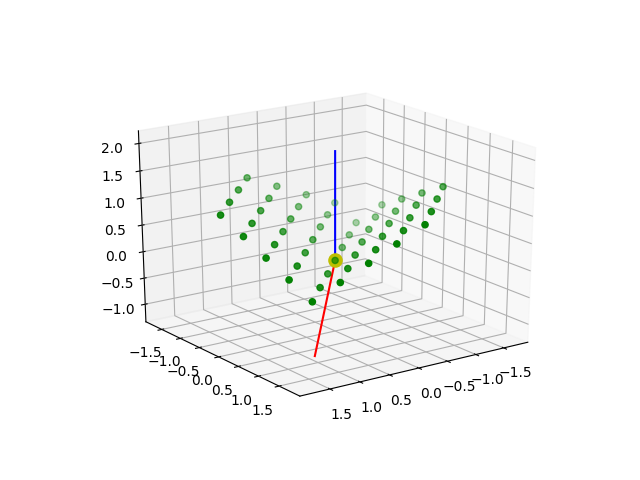

In [24]:
aim = np.array([0,0,1])
normal_line = line(normal, 3)
aim_line = line(aim, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(normal_line[:,0],normal_line[:,1],normal_line[:,2], c="r")
ax.plot(aim_line[:,0],aim_line[:,1],aim_line[:,2], c="b")
ax.scatter(normalized_neighborhood[:,0],normalized_neighborhood[:,1],normalized_neighborhood[:,2], c="g")
ax.scatter(normalized_neighborhood[indx_new,0],normalized_neighborhood[indx_new,1], normalized_neighborhood[indx_new,2], c="y", s=90 )


<IPython.core.display.Javascript object>


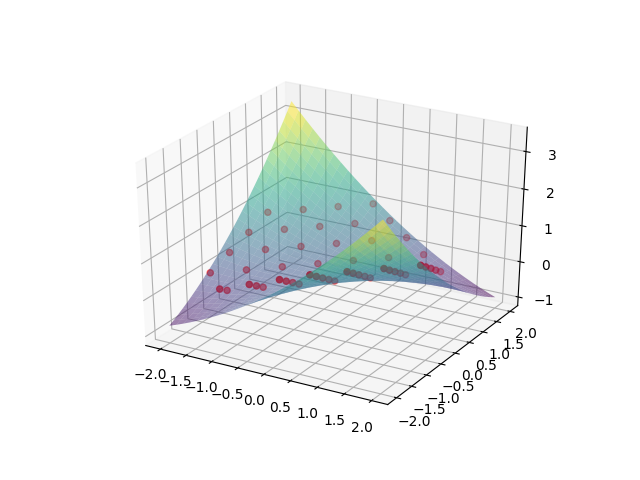

In [25]:
x = np.outer(np.linspace(-2, 2, 30), np.ones(30))
y = x.copy().T # transpose
z = p[0]/2 * (x**2) + p[1] * (x*y) + p[2]/2 * (y**2) + p[3] * x + p[4] * y + p[5]
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z,cmap='viridis', edgecolor='none', alpha = 0.5)
ax.scatter(normalized_neighborhood[:,0],normalized_neighborhood[:,1],normalized_neighborhood[:,2], c="r")

## Cube

<IPython.core.display.Javascript object>


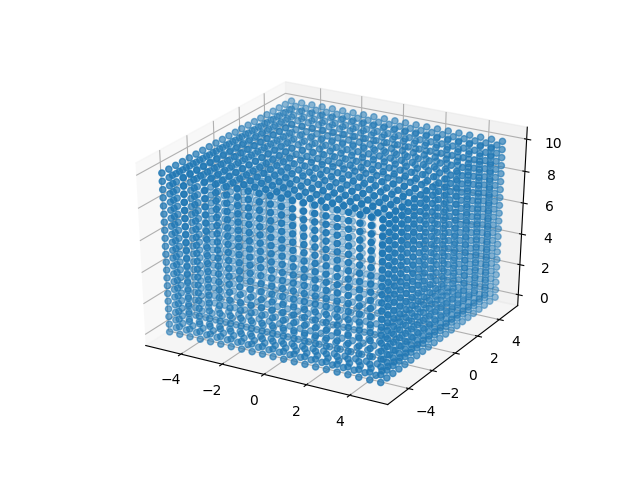

7206 points


In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cube = create_cube(edge_length=10,grid_size=0.5)
cube += 0.001*np.random.randn(*cube.shape)
ax.scatter(cube[:,0],cube[:,1],cube[:,2])
print(cube.size,'points')
fig.savefig("cube")

In [27]:
MG = base.Meshgrid(cube)
diag = np.linalg.norm(np.min(cube,axis=0) - np.max(cube,axis=0))
max_dist = 0.1*diag
#print('Max_dist:',max_dist)
#MG.compute_all_harris_responses(neigh_flag='ring', neigh_args={'max_dist':max_dist}, k_harris=0.04)
MG.compute_all_harris_responses(neigh_flag='k', neigh_args={'k':50}, k_harris=0.04)
#MG.compute_all_harris_responses(neigh_flag='dist', neigh_args={'distance':0.15}, k_harris=0.04)

harris_values = MG.harris_values
print('min harris   ',np.min(harris_values))
print('median harris',np.median(harris_values))
print('max harris   ',np.max(harris_values))

min harris    -0.07404787917322643
median harris 7.763865565425976e-17
max harris    0.4039224008729325


<IPython.core.display.Javascript object>


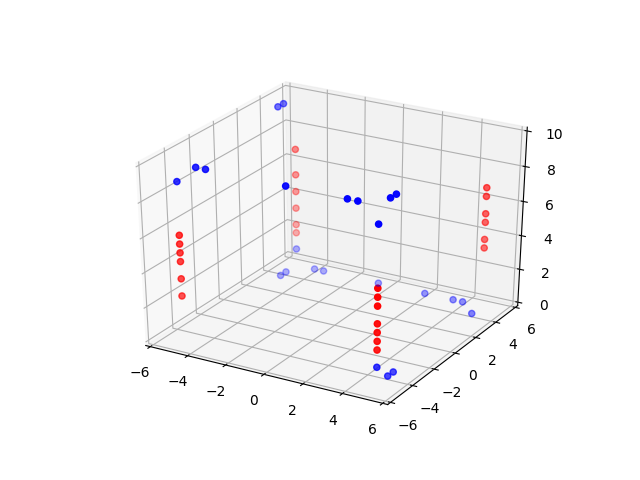

In [28]:
indices_smallest = np.argsort(harris_values)[int(0.0*len(harris_values)):int(0.01*len(harris_values))]
indices_largest = np.argsort(harris_values)[int(0.99*len(harris_values)):int(1.0*len(harris_values))]
cube_smallest = cube[indices_smallest]
cube_largest = cube[indices_largest]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cube_smallest[:,0],cube_smallest[:,1],cube_smallest[:,2],c='b')
ax.scatter(cube_largest[:,0],cube_largest[:,1],cube_largest[:,2],c='r')
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.set_zlim(0,10)
fig.savefig("cube_1_highest_lowest")

<IPython.core.display.Javascript object>


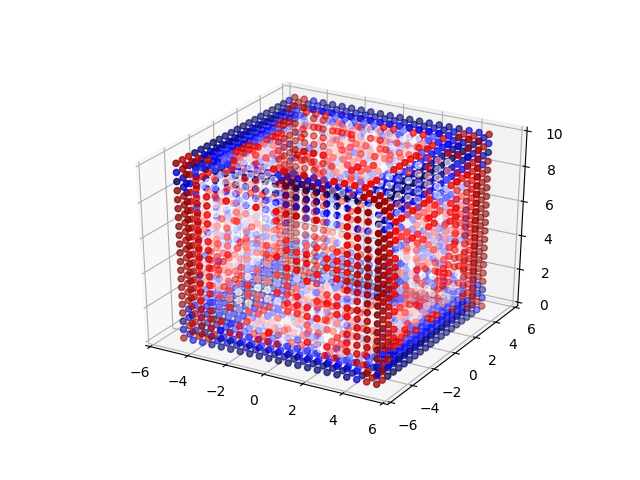

In [29]:
indices = np.argsort(harris_values)[int(0*len(harris_values)):int(1.0*len(harris_values))]
cube_new = cube[indices]
harris_new = harris_values[indices]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cube_new[:,0],cube_new[:,1],cube_new[:,2],c=np.linspace(0,1,len(cube_new)),cmap='seismic')
#ax.scatter(cube_new[:,0],cube_new[:,1],cube_new[:,2],c=harris_new,cmap='seismic')
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.set_zlim(0,10)
fig.savefig("cube_all")

# Corner of the Cube

<IPython.core.display.Javascript object>


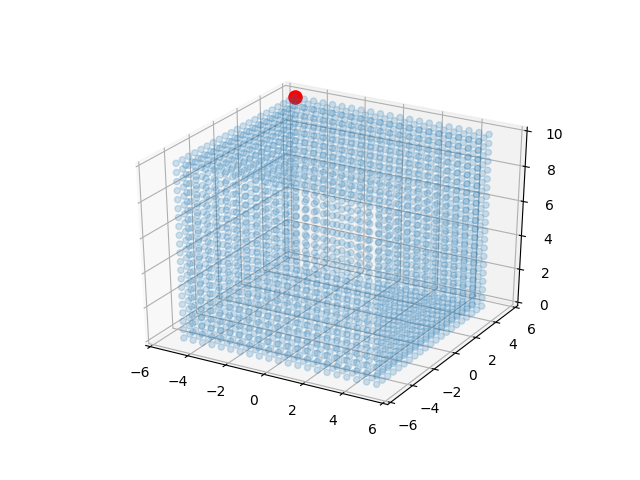

(0, 10)

In [30]:
a1 = 2381
a2 = 2382
cube_smallest = cube[a1:a2]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cube_smallest[:,0],cube_smallest[:,1],cube_smallest[:,2],c='r', s = 90)
ax.scatter(cube[:,0],cube[:,1],cube[:,2], alpha= 0.2)
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.set_zlim(0,10)

In [31]:
harris,rotated_neigh,orig_neighborhood, centroid, normal,normalized_neighborhood,new_points_before_centered,p, indx_new, graph= MG.compute_all_harris_responses_debug( 2381 ,neigh_flag = 'k', neigh_args = {'k':50},  k_harris = 0.04)

### Neighborhood

<IPython.core.display.Javascript object>


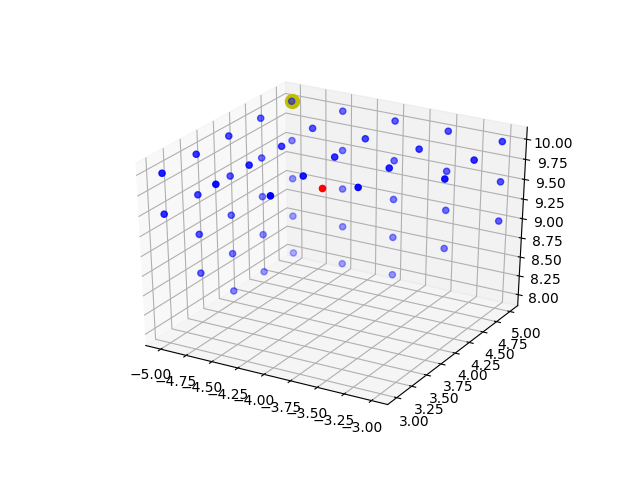

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(orig_neighborhood[:,0],orig_neighborhood[:,1],orig_neighborhood[:,2], c='b')
ax.scatter(orig_neighborhood[indx_new,0],orig_neighborhood[indx_new,1],orig_neighborhood[indx_new,2], c='y', s = 100)
ax.scatter(centroid[0],centroid[1],centroid[2], c='r')

### Centered neighborhood (before rotation) 

<IPython.core.display.Javascript object>


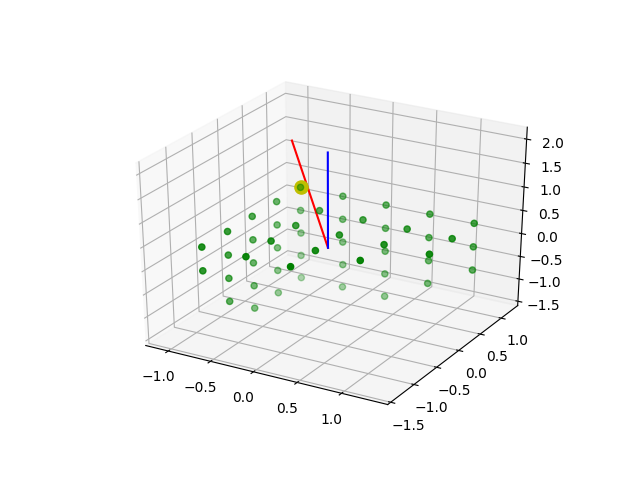

In [33]:
centered_neigh = orig_neighborhood - centroid
aim = np.array([0,0,1])
normal_line = line(normal, 3)
aim_line = line(aim, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(normal_line[:,0],normal_line[:,1],normal_line[:,2], c="r")
ax.plot(aim_line[:,0],aim_line[:,1],aim_line[:,2], c="b")
ax.scatter(centered_neigh[:,0],centered_neigh[:,1],centered_neigh[:,2], c="g")
ax.scatter(centered_neigh[indx_new,0],centered_neigh[indx_new,1], centered_neigh[indx_new,2], c="y", s=90 )

### Centered and rotated neighborhood

<IPython.core.display.Javascript object>


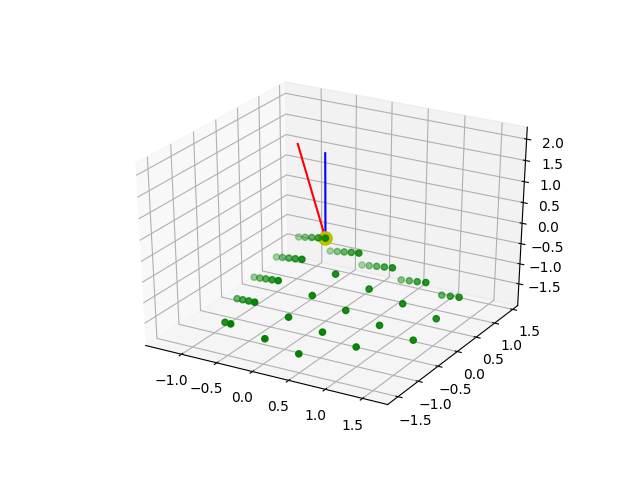

In [34]:
aim = np.array([0,0,1])
normal_line = line(normal, 3)
aim_line = line(aim, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(normal_line[:,0],normal_line[:,1],normal_line[:,2], c="r")
ax.plot(aim_line[:,0],aim_line[:,1],aim_line[:,2], c="b")
ax.scatter(normalized_neighborhood[:,0],normalized_neighborhood[:,1],normalized_neighborhood[:,2], c="g")
ax.scatter(normalized_neighborhood[indx_new,0],normalized_neighborhood[indx_new,1], normalized_neighborhood[indx_new,2], c="y", s=90 )


### Quadratic surface 

<IPython.core.display.Javascript object>


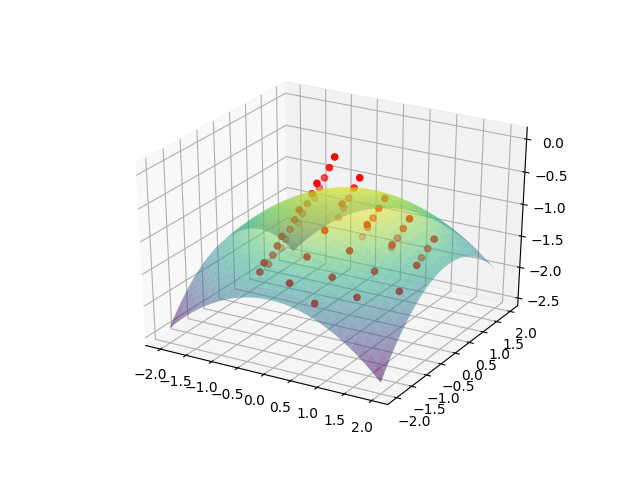

In [43]:
x = np.outer(np.linspace(-2, 2, 30), np.ones(30))
y = x.copy().T # transpose
z = p[0]/2 * (x**2) + p[1] * (x*y) + p[2]/2 * (y**2) + p[3] * x + p[4] * y + p[5]
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z,cmap='viridis', edgecolor='none', alpha = 0.5)
ax.scatter(normalized_neighborhood[:,0],normalized_neighborhood[:,1],normalized_neighborhood[:,2], c="r")


In [44]:
fig.savefig("cube_corner")

In [45]:
harris

0.1144237586453932

# Edge, horizontal

<IPython.core.display.Javascript object>


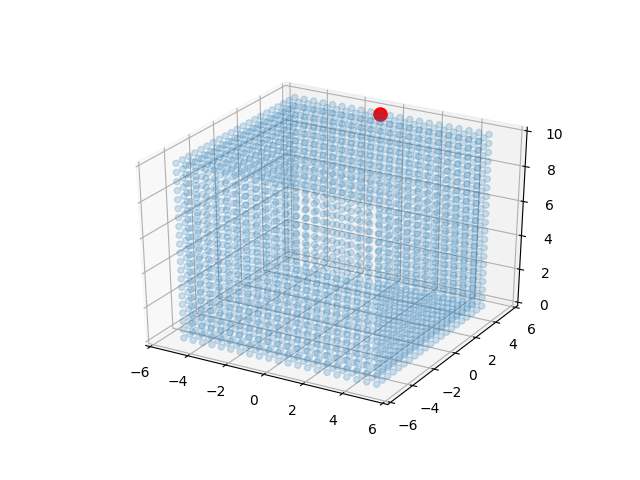

(0, 10)

In [46]:
a1 = 2390
a2 = 2391
cube_edge = cube[a1:a2]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cube_edge[:,0],cube_edge[:,1],cube_edge[:,2],c='r', s = 90)
ax.scatter(cube[:,0],cube[:,1],cube[:,2], alpha= 0.2)
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.set_zlim(0,10)

<IPython.core.display.Javascript object>


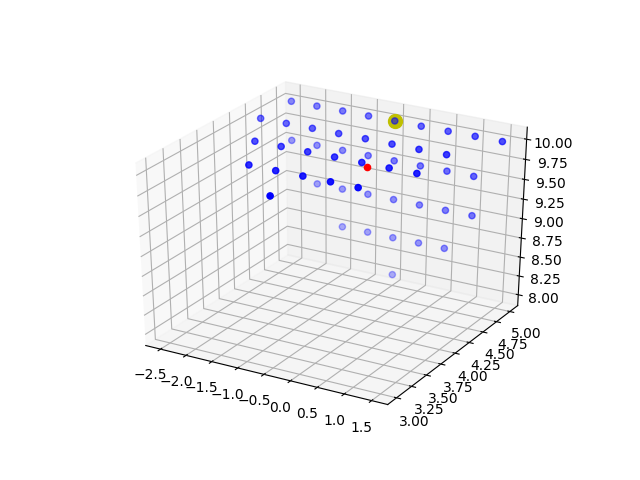

In [47]:
harris,rotated_neigh,orig_neighborhood, centroid, normal,normalized_neighborhood,new_points_before_centered,p, new_index, graph= MG.compute_all_harris_responses_debug( 2390 ,neigh_flag = 'k', neigh_args = {'k':50},  k_harris = 0.04)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(orig_neighborhood[:,0],orig_neighborhood[:,1],orig_neighborhood[:,2], c='b')
ax.scatter(orig_neighborhood[new_index,0],orig_neighborhood[new_index,1],orig_neighborhood[new_index,2], c='y', s = 100)
ax.scatter(centroid[0],centroid[1],centroid[2], c='r')

<IPython.core.display.Javascript object>


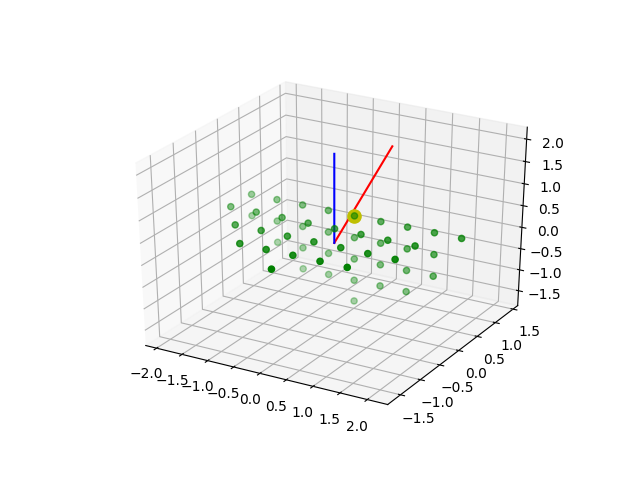

In [48]:
centered_neigh = orig_neighborhood - centroid
aim = np.array([0,0,1])
normal_line = line(normal, 3)
aim_line = line(aim, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(normal_line[:,0],normal_line[:,1],normal_line[:,2], c="r")
ax.plot(aim_line[:,0],aim_line[:,1],aim_line[:,2], c="b")
ax.scatter(centered_neigh[:,0],centered_neigh[:,1],centered_neigh[:,2], c="g")
ax.scatter(centered_neigh[new_index,0],centered_neigh[new_index,1], centered_neigh[new_index,2], c="y", s=90 )

<IPython.core.display.Javascript object>


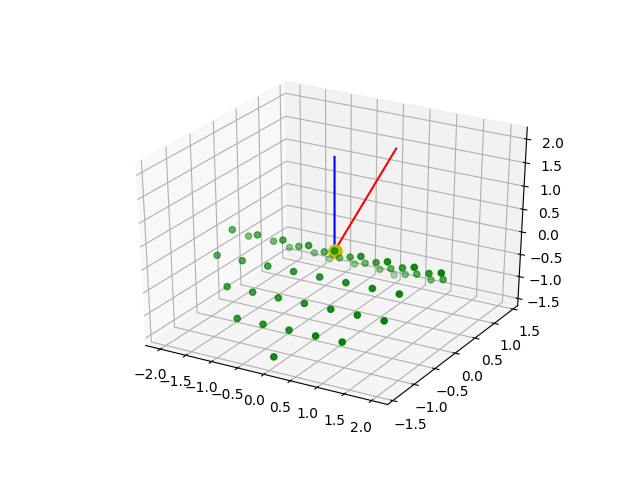

In [49]:
aim = np.array([0,0,1])
normal_line = line(normal, 3)
aim_line = line(aim, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(normal_line[:,0],normal_line[:,1],normal_line[:,2], c="r")
ax.plot(aim_line[:,0],aim_line[:,1],aim_line[:,2], c="b")
ax.scatter(normalized_neighborhood[:,0],normalized_neighborhood[:,1],normalized_neighborhood[:,2], c="g")
ax.scatter(normalized_neighborhood[new_index,0],normalized_neighborhood[new_index,1], normalized_neighborhood[new_index,2], c="y", s=90 )


<IPython.core.display.Javascript object>


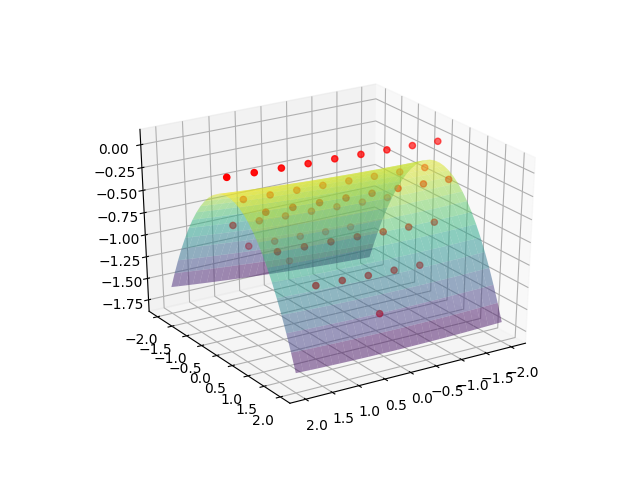

In [50]:
x = np.outer(np.linspace(-2, 2, 30), np.ones(30))
y = x.copy().T # transpose
z = p[0]/2 * (x**2) + p[1] * (x*y) + p[2]/2 * (y**2) + p[3] * x + p[4] * y + p[5]
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z,cmap='viridis', edgecolor='none', alpha = 0.5)
ax.scatter(normalized_neighborhood[:,0],normalized_neighborhood[:,1],normalized_neighborhood[:,2], c="r")

In [52]:
fig.savefig("cube_edge_horizontal2")

In [ ]:
harris

## Edge horizontal 2

In [ ]:
a1 = 1973
a2 = 1974
cube_edge = cube[a1:a2]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cube_edge[:,0],cube_edge[:,1],cube_edge[:,2],c='r', s = 90)
ax.scatter(cube[:,0],cube[:,1],cube[:,2], alpha= 0.2)
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.set_zlim(0,10)

In [ ]:
harris,rotated_neigh,orig_neighborhood, centroid, normal,normalized_neighborhood,new_points_before_centered,p, new_index, graph= MG.compute_all_harris_responses_debug( 1973 ,neigh_flag = 'k', neigh_args = {'k':50},  k_harris = 0.04)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(orig_neighborhood[:,0],orig_neighborhood[:,1],orig_neighborhood[:,2], c='b')
ax.scatter(orig_neighborhood[new_index,0],orig_neighborhood[new_index,1],orig_neighborhood[new_index,2], c='y', s = 100)
ax.scatter(centroid[0],centroid[1],centroid[2], c='r')

In [ ]:
centered_neigh = orig_neighborhood - centroid
aim = np.array([0,0,1])
normal_line = line(normal, 3)
aim_line = line(aim, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(normal_line[:,0],normal_line[:,1],normal_line[:,2], c="r")
ax.plot(aim_line[:,0],aim_line[:,1],aim_line[:,2], c="b")
ax.scatter(centered_neigh[:,0],centered_neigh[:,1],centered_neigh[:,2], c="g")
ax.scatter(centered_neigh[new_index,0],centered_neigh[new_index,1], centered_neigh[new_index,2], c="y", s=90 )

In [ ]:
aim = np.array([0,0,1])
normal_line = line(normal, 3)
aim_line = line(aim, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(normal_line[:,0],normal_line[:,1],normal_line[:,2], c="r")
ax.plot(aim_line[:,0],aim_line[:,1],aim_line[:,2], c="b")
ax.scatter(normalized_neighborhood[:,0],normalized_neighborhood[:,1],normalized_neighborhood[:,2], c="g")
ax.scatter(normalized_neighborhood[new_index,0],normalized_neighborhood[new_index,1], normalized_neighborhood[new_index,2], c="y", s=90 )


In [ ]:
x = np.outer(np.linspace(-2, 2, 30), np.ones(30))
y = x.copy().T # transpose
z = p[0]/2 * (x**2) + p[1] * (x*y) + p[2]/2 * (y**2) + p[3] * x + p[4] * y + p[5]
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z,cmap='viridis', edgecolor='none', alpha = 0.5)
ax.scatter(normalized_neighborhood[:,0],normalized_neighborhood[:,1],normalized_neighborhood[:,2], c="r")

## Edge vertical

<IPython.core.display.Javascript object>


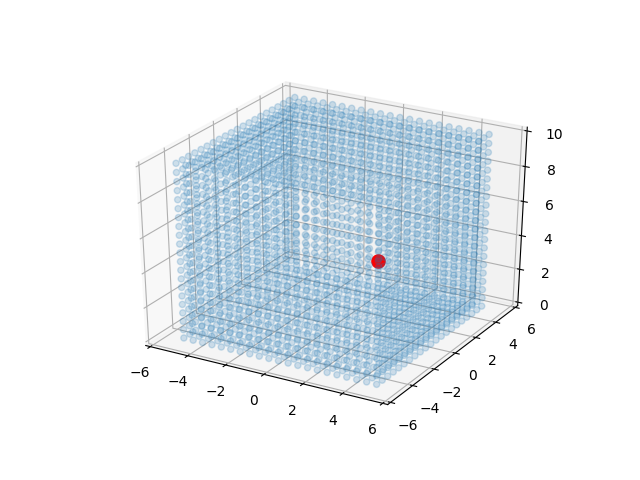

(0, 10)

In [53]:
a1 = 1541
a2 = 1542
cube_edge = cube[a1:a2]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cube_edge[:,0],cube_edge[:,1],cube_edge[:,2],c='r', s = 90)
ax.scatter(cube[:,0],cube[:,1],cube[:,2], alpha= 0.2)
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.set_zlim(0,10)

/home/bjoern/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


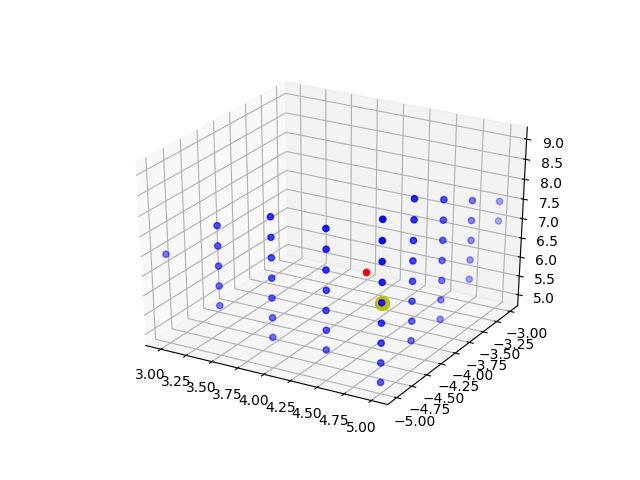

In [54]:
harris,rotated_neigh,orig_neighborhood, centroid, normal,normalized_neighborhood,new_points_before_centered,p, new_index, graph= MG.compute_all_harris_responses_debug( 1541 ,neigh_flag = 'k', neigh_args = {'k':50},  k_harris = 0.04)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(orig_neighborhood[:,0],orig_neighborhood[:,1],orig_neighborhood[:,2], c='b')
ax.scatter(orig_neighborhood[new_index,0],orig_neighborhood[new_index,1],orig_neighborhood[new_index,2], c='y', s = 100)
ax.scatter(centroid[0],centroid[1],centroid[2], c='r')

<IPython.core.display.Javascript object>


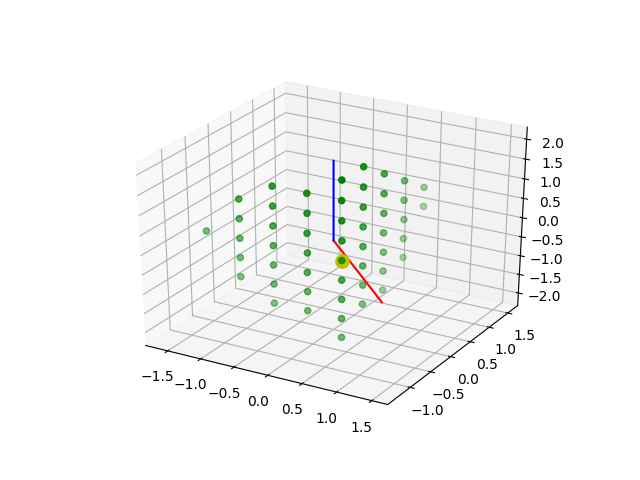

In [55]:
centered_neigh = orig_neighborhood - centroid
aim = np.array([0,0,1])
normal_line = line(normal, 3)
aim_line = line(aim, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(normal_line[:,0],normal_line[:,1],normal_line[:,2], c="r")
ax.plot(aim_line[:,0],aim_line[:,1],aim_line[:,2], c="b")
ax.scatter(centered_neigh[:,0],centered_neigh[:,1],centered_neigh[:,2], c="g")
ax.scatter(centered_neigh[new_index,0],centered_neigh[new_index,1], centered_neigh[new_index,2], c="y", s=90 )

<IPython.core.display.Javascript object>


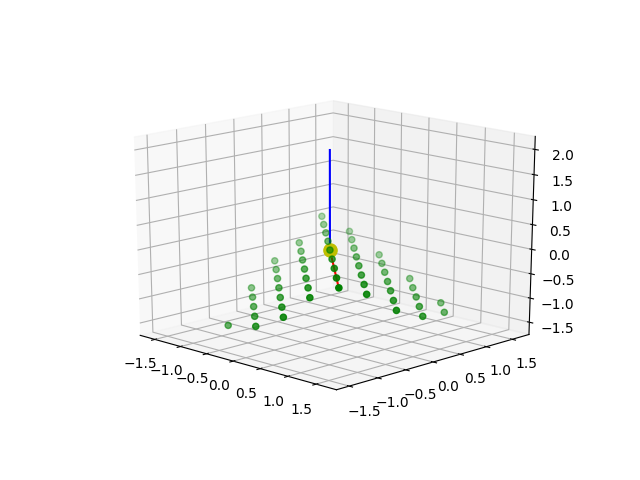

In [56]:
aim = np.array([0,0,1])
normal_line = line(normal, 3)
aim_line = line(aim, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(normal_line[:,0],normal_line[:,1],normal_line[:,2], c="r")
ax.plot(aim_line[:,0],aim_line[:,1],aim_line[:,2], c="b")
ax.scatter(normalized_neighborhood[:,0],normalized_neighborhood[:,1],normalized_neighborhood[:,2], c="g")
ax.scatter(normalized_neighborhood[new_index,0],normalized_neighborhood[new_index,1], normalized_neighborhood[new_index,2], c="y", s=90 )


<IPython.core.display.Javascript object>


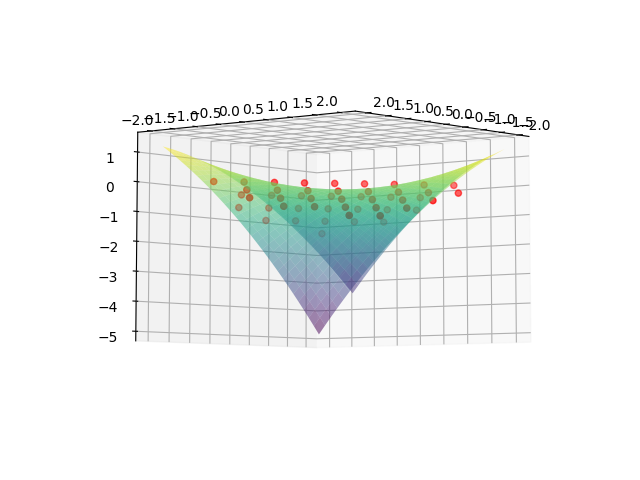

In [57]:
x = np.outer(np.linspace(-2, 2, 30), np.ones(30))
y = x.copy().T # transpose
z = p[0]/2 * (x**2) + p[1] * (x*y) + p[2]/2 * (y**2) + p[3] * x + p[4] * y + p[5]
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z,cmap='viridis', edgecolor='none', alpha = 0.5)
ax.scatter(normalized_neighborhood[:,0],normalized_neighborhood[:,1],normalized_neighborhood[:,2], c="r")

In [58]:
harris

0.3499956742019087

In [60]:
fig.savefig("cube_edge_vertical2")

In [ ]:
A = p[3]**2 + 2*p[0]**2 + 2*p[1]**2
B = p[4]**2 + 2*p[1]**2 + 2*p[2]**2
C = p[3]*p[4] + 2*p[0]*p[1] + 2*p[1]*p[2]
E = np.array([[A,C],[C,B]])
harris_calc = (A*B-C**2) - 0.04*((A+B)**2) # det(E) - k*(trace(E)**2)

In [ ]:
A

In [ ]:
B

In [ ]:
C

## Edge vertical 2 

<IPython.core.display.Javascript object>


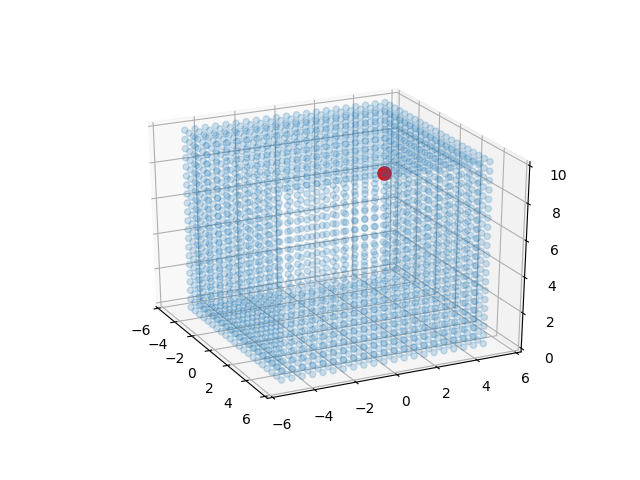

(0, 10)

In [61]:
a1 = 1341
a2 = 1342
cube_edge = cube[a1:a2]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cube_edge[:,0],cube_edge[:,1],cube_edge[:,2],c='r', s = 90)
ax.scatter(cube[:,0],cube[:,1],cube[:,2], alpha= 0.2)
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.set_zlim(0,10)

/home/bjoern/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


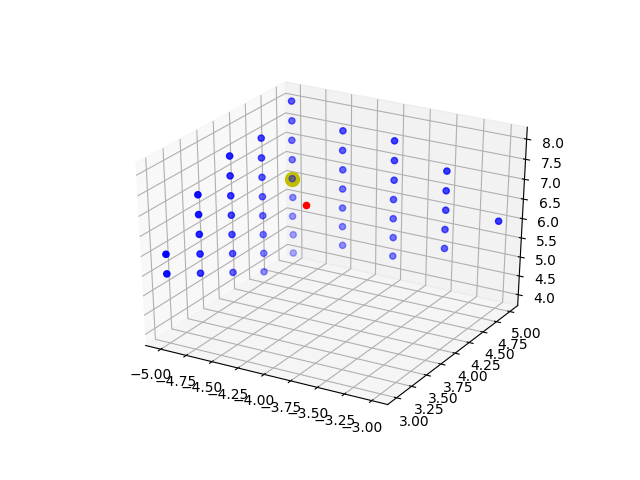

In [62]:
harris,rotated_neigh,orig_neighborhood, centroid, normal,normalized_neighborhood,new_points_before_centered,p, new_index, graph= MG.compute_all_harris_responses_debug( 1341 ,neigh_flag = 'k', neigh_args = {'k':50},  k_harris = 0.04)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(orig_neighborhood[:,0],orig_neighborhood[:,1],orig_neighborhood[:,2], c='b')
ax.scatter(orig_neighborhood[new_index,0],orig_neighborhood[new_index,1],orig_neighborhood[new_index,2], c='y', s = 100)
ax.scatter(centroid[0],centroid[1],centroid[2], c='r')

<IPython.core.display.Javascript object>


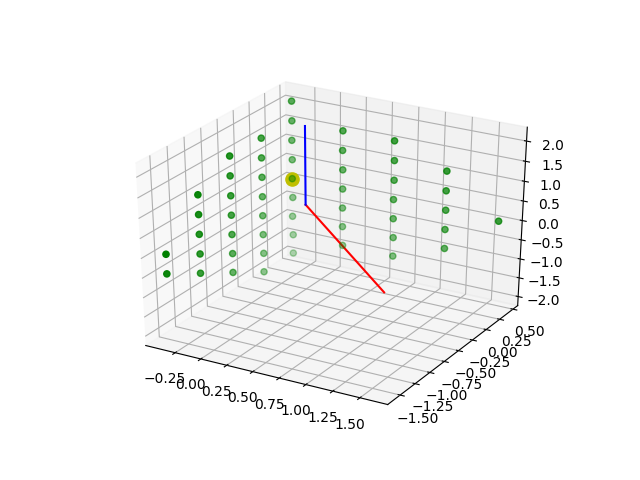

In [63]:
centered_neigh = orig_neighborhood - centroid
aim = np.array([0,0,1])
normal_line = line(normal, 3)
aim_line = line(aim, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(normal_line[:,0],normal_line[:,1],normal_line[:,2], c="r")
ax.plot(aim_line[:,0],aim_line[:,1],aim_line[:,2], c="b")
ax.scatter(centered_neigh[:,0],centered_neigh[:,1],centered_neigh[:,2], c="g")
ax.scatter(centered_neigh[new_index,0],centered_neigh[new_index,1], centered_neigh[new_index,2], c="y", s=90 )

<IPython.core.display.Javascript object>


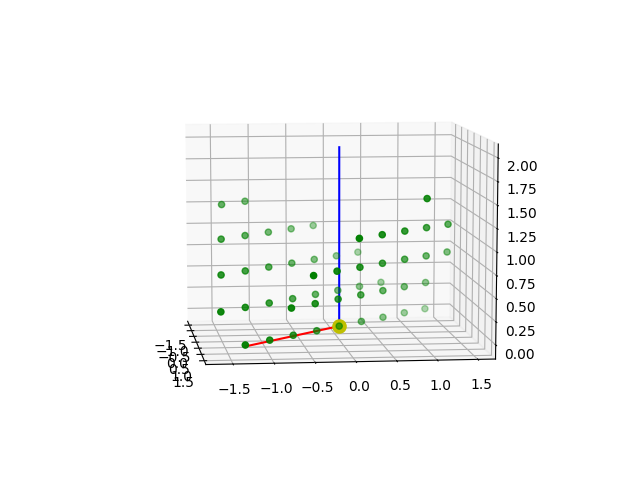

In [64]:
aim = np.array([0,0,1])
normal_line = line(normal, 3)
aim_line = line(aim, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(normal_line[:,0],normal_line[:,1],normal_line[:,2], c="r")
ax.plot(aim_line[:,0],aim_line[:,1],aim_line[:,2], c="b")
ax.scatter(normalized_neighborhood[:,0],normalized_neighborhood[:,1],normalized_neighborhood[:,2], c="g")
ax.scatter(normalized_neighborhood[new_index,0],normalized_neighborhood[new_index,1], normalized_neighborhood[new_index,2], c="y", s=90 )


<IPython.core.display.Javascript object>


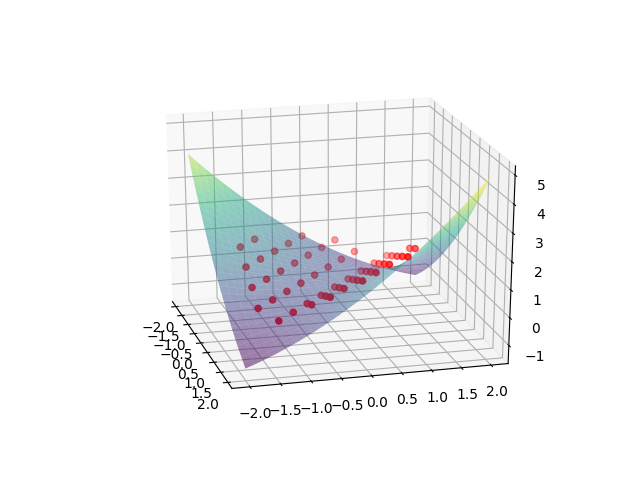

In [65]:
x = np.outer(np.linspace(-2, 2, 30), np.ones(30))
y = x.copy().T # transpose
z = p[0]/2 * (x**2) + p[1] * (x*y) + p[2]/2 * (y**2) + p[3] * x + p[4] * y + p[5]
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z,cmap='viridis', edgecolor='none', alpha = 0.5)
ax.scatter(normalized_neighborhood[:,0],normalized_neighborhood[:,1],normalized_neighborhood[:,2], c="r")

### Edge Vertical with corner

In [ ]:
a1 = 1941
a2 = 1942
cube_edge = cube[a1:a2]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cube_edge[:,0],cube_edge[:,1],cube_edge[:,2],c='r', s = 90)
ax.scatter(cube[:,0],cube[:,1],cube[:,2], alpha= 0.2)
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.set_zlim(0,10)

In [ ]:
harris,rotated_neigh,orig_neighborhood, centroid, normal,normalized_neighborhood,new_points_before_centered,p, new_index, graph= MG.compute_all_harris_responses_debug( 1941 ,neigh_flag = 'k', neigh_args = {'k':50},  k_harris = 0.04)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(orig_neighborhood[:,0],orig_neighborhood[:,1],orig_neighborhood[:,2], c='b')
ax.scatter(orig_neighborhood[new_index,0],orig_neighborhood[new_index,1],orig_neighborhood[new_index,2], c='y', s = 100)
ax.scatter(centroid[0],centroid[1],centroid[2], c='r')

In [ ]:
centered_neigh = orig_neighborhood - centroid
aim = np.array([0,0,1])
normal_line = line(normal, 3)
aim_line = line(aim, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(normal_line[:,0],normal_line[:,1],normal_line[:,2], c="r")
ax.plot(aim_line[:,0],aim_line[:,1],aim_line[:,2], c="b")
ax.scatter(centered_neigh[:,0],centered_neigh[:,1],centered_neigh[:,2], c="g")
ax.scatter(centered_neigh[new_index,0],centered_neigh[new_index,1], centered_neigh[new_index,2], c="y", s=90 )

In [ ]:
aim = np.array([0,0,1])
normal_line = line(normal, 3)
aim_line = line(aim, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(normal_line[:,0],normal_line[:,1],normal_line[:,2], c="r")
ax.plot(aim_line[:,0],aim_line[:,1],aim_line[:,2], c="b")
ax.scatter(normalized_neighborhood[:,0],normalized_neighborhood[:,1],normalized_neighborhood[:,2], c="g")
ax.scatter(normalized_neighborhood[new_index,0],normalized_neighborhood[new_index,1], normalized_neighborhood[new_index,2], c="y", s=90 )


In [ ]:
x = np.outer(np.linspace(-2, 2, 30), np.ones(30))
y = x.copy().T # transpose
z = p[0]/2 * (x**2) + p[1] * (x*y) + p[2]/2 * (y**2) + p[3] * x + p[4] * y + p[5]
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z,cmap='viridis', edgecolor='none', alpha = 0.5)
ax.scatter(normalized_neighborhood[:,0],normalized_neighborhood[:,1],normalized_neighborhood[:,2], c="r")

In [ ]:
harris

## Plain surface

In [ ]:
a1 = 1230
a2 = 1231
cube_edge = cube[a1:a2]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cube_edge[:,0],cube_edge[:,1],cube_edge[:,2],c='r', s = 90)
ax.scatter(cube[:,0],cube[:,1],cube[:,2], alpha= 0.2)
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.set_zlim(0,10)

In [ ]:
harris,rotated_neigh,orig_neighborhood, centroid, normal,normalized_neighborhood,new_points_before_centered,p, new_index, graph= MG.compute_all_harris_responses_debug( 1230 ,neigh_flag = 'k', neigh_args = {'k':50},  k_harris = 0.04)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(orig_neighborhood[:,0],orig_neighborhood[:,1],orig_neighborhood[:,2], c='b')
ax.scatter(orig_neighborhood[new_index,0],orig_neighborhood[new_index,1],orig_neighborhood[new_index,2], c='y', s = 100)
ax.scatter(centroid[0],centroid[1],centroid[2], c='r')

In [ ]:
centered_neigh = orig_neighborhood - centroid
aim = np.array([0,0,1])
normal_line = line(normal, 3)
aim_line = line(aim, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(normal_line[:,0],normal_line[:,1],normal_line[:,2], c="r")
ax.plot(aim_line[:,0],aim_line[:,1],aim_line[:,2], c="b")
ax.scatter(centered_neigh[:,0],centered_neigh[:,1],centered_neigh[:,2], c="g")
ax.scatter(centered_neigh[new_index,0],centered_neigh[new_index,1], centered_neigh[new_index,2], c="y", s=90 )

In [ ]:
aim = np.array([0,0,1])
normal_line = line(normal, 3)
aim_line = line(aim, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(normal_line[:,0],normal_line[:,1],normal_line[:,2], c="r")
ax.plot(aim_line[:,0],aim_line[:,1],aim_line[:,2], c="b")
ax.scatter(normalized_neighborhood[:,0],normalized_neighborhood[:,1],normalized_neighborhood[:,2], c="g")
ax.scatter(normalized_neighborhood[new_index,0],normalized_neighborhood[new_index,1], normalized_neighborhood[new_index,2], c="y", s=90 )

In [ ]:
x = np.outer(np.linspace(-2, 2, 30), np.ones(30))
y = x.copy().T # transpose
z = p[0]/2 * (x**2) + p[1] * (x*y) + p[2]/2 * (y**2) + p[3] * x + p[4] * y + p[5]
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z,cmap='viridis', edgecolor='none', alpha = 0.5)
ax.scatter(normalized_neighborhood[:,0],normalized_neighborhood[:,1],normalized_neighborhood[:,2], c="r")

In [ ]:
harris